In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torchvision.io import read_image
import pandas as pd
import os
from sklearn import preprocessing
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import cv2
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
zip_file_path = '/content/drive/MyDrive/ship dataset/Ship Classification.v4i.multiclass.zip'

In [4]:
import zipfile

# zip 파일을 열고 압축을 풀기
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/images')

In [5]:
# 각 라벨의 개수 확인
df = pd.read_csv('/content/images/train/_classes.csv')
image_dir_train = '/content/images/train/'
image_dir_valid = '/content/images/valid/'
image_dir_test = '/content/images/test/'
counts = df.iloc[:, 1:].sum(axis=0)
print(counts)

Aircraft Carrier     493
Bulkers              178
Car-carrier         1128
Container-Ship       512
Cruise               485
DDG                  549
Recreational         156
Sailboat             155
Submarine            480
Tug                  494
dtype: int64


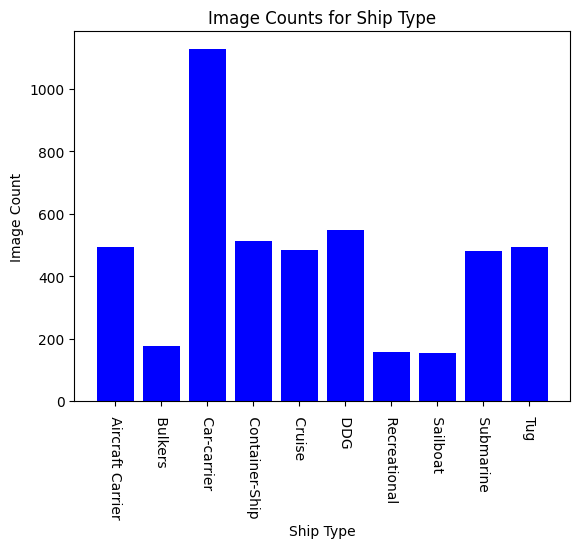

In [6]:
# 막대 그래프 생성
plt.bar(df.columns[1:], counts, color='blue')
plt.xticks(rotation=-90)
plt.xlabel('Ship Type')
plt.ylabel('Image Count')
plt.title('Image Counts for Ship Type')
plt.show()

In [7]:
# 과도하게 많은 라벨 개수 줄이기
car_carrier = df[df[' Car-carrier'] == 1]
car_carrier_undersampled = car_carrier.sample(frac=0.5, random_state=83)
other_samples = df[df[' Car-carrier'] != 1]
undersampled_df = pd.concat([car_carrier_undersampled, other_samples])

In [8]:
counts = undersampled_df.iloc[:, 1:].sum(axis=0)
print(counts)

Aircraft Carrier    493
Bulkers             178
Car-carrier         564
Container-Ship      512
Cruise              485
DDG                 549
Recreational        156
Sailboat            155
Submarine           480
Tug                 494
dtype: int64


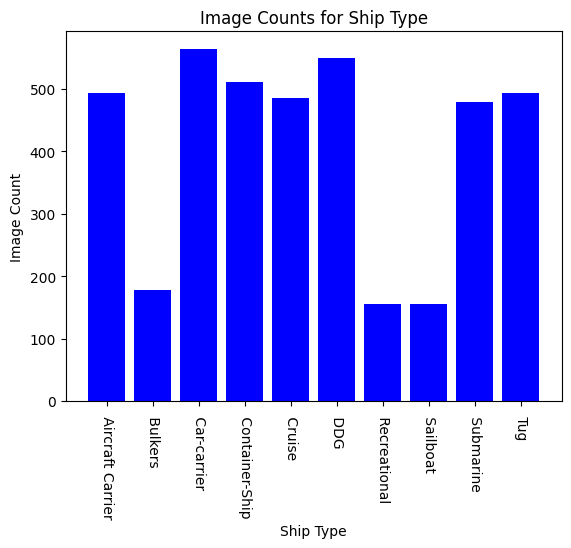

In [9]:
plt.bar(undersampled_df.columns[1:], counts, color='blue')
plt.xticks(rotation=-90)
plt.xlabel('Ship Type')
plt.ylabel('Image Count')
plt.title('Image Counts for Ship Type')
plt.show()

In [10]:
# 과도하게 적은 라벨 개수 좌우반전으로 늘리기
# 오버샘플링된 이미지를 저장할 리스트 초기화
expanded_data = []

# 라벨을 선택하여 해당 라벨에만 좌우반전 이미지를 추가
labels_to_flip = [' Bulkers', ' Recreational', ' Sailboat']

# 'undersampled_df'에서 각 라벨에 대해 처리
for label in labels_to_flip:
    label_data = undersampled_df[undersampled_df[label] == 1]  # 해당 라벨에 해당하는 데이터를 필터링

    for _, row in label_data.iterrows():
        # 이미지 경로를 'filename' 컬럼에서 가져오고, 전체 경로를 생성
        img_path = os.path.join(image_dir_train, row['filename'])

        # 이미지를 OpenCV로 열기
        img = cv2.imread(img_path)

        # 원본 이미지를 리스트에 추가
        expanded_data.append(row)  # 원본 이미지 데이터(row)는 그대로 추가

        # 좌우 반전된 이미지를 추가
        flipped_img = cv2.flip(img, 1)  # 1은 좌우 반전
        flipped_img_path = os.path.join(image_dir_train, 'flipped', row['filename'].replace('.jpg', '_flipped.jpg'))  # 'flipped' 디렉토리에 저장
        os.makedirs(os.path.dirname(flipped_img_path), exist_ok=True)  # 'flipped' 디렉토리가 없으면 생성
        cv2.imwrite(flipped_img_path, flipped_img)  # 좌우 반전된 이미지를 저장

        # 좌우 반전된 이미지에 대한 데이터를 그대로 복사하고 filename만 수정하여 추가
        flipped_row = row.copy()
        flipped_row['filename'] = flipped_img_path  # filename만 반전된 이미지 경로로 수정
        expanded_data.append(flipped_row)  # 좌우 반전된 이미지 데이터를 추가

# 나머지 라벨에 해당하는 데이터는 그대로 저장
for label in undersampled_df.columns:
    if label not in labels_to_flip and label != 'filename':  # 'filename'은 제외하고, 반전 처리된 라벨 제외
        label_data = undersampled_df[undersampled_df[label] == 1]
        for _, row in label_data.iterrows():
            expanded_data.append(row)  # 원본 이미지 데이터(row)는 그대로 추가

# 최종적으로 확장된 데이터셋을 DataFrame으로 변환
oversampled_df = pd.DataFrame(expanded_data)

In [11]:
counts = oversampled_df.iloc[:, 1:].sum(axis=0)
print(counts)

Aircraft Carrier    493
Bulkers             356
Car-carrier         564
Container-Ship      512
Cruise              485
DDG                 549
Recreational        312
Sailboat            310
Submarine           480
Tug                 494
dtype: int64


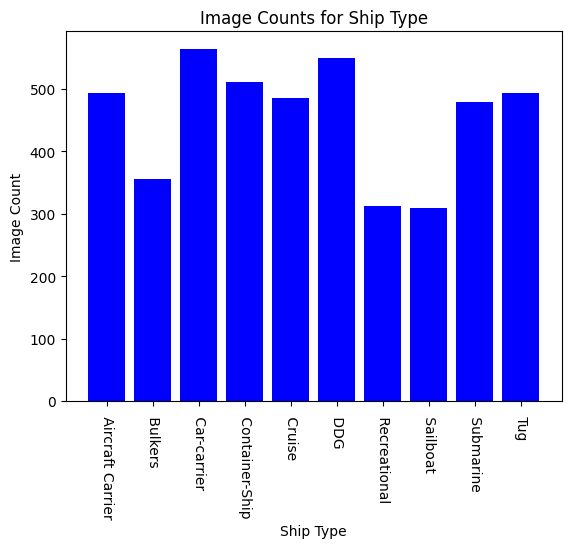

In [12]:
# 수정된 데이터 막대 그래프 생성
plt.bar(oversampled_df.columns[1:], counts, color='blue')
plt.xticks(rotation=-90)
plt.xlabel('Ship Type')
plt.ylabel('Image Count')
plt.title('Image Counts for Ship Type')
plt.show()

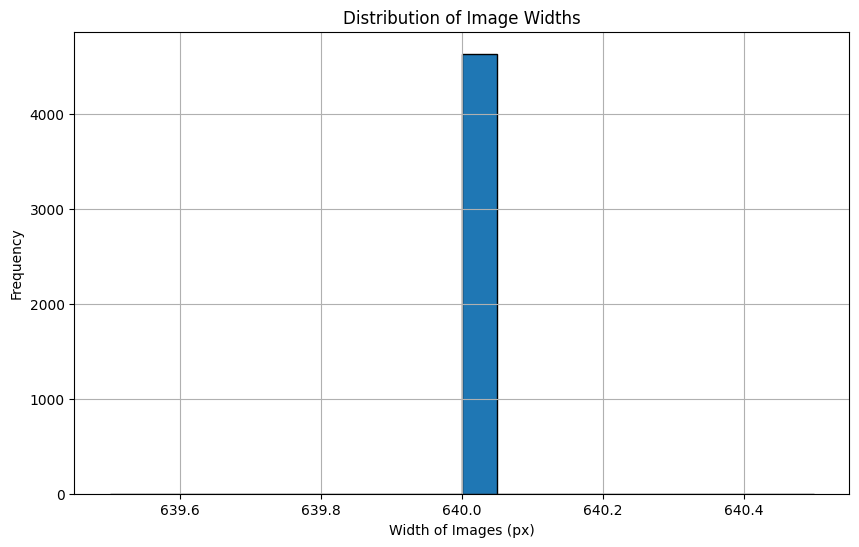

In [13]:
image_widths = []
image_files = [f for f in os.listdir(image_dir_train) if f.endswith('.jpg')]

# 각 이미지의 가로 길이를 추출
for image_file in image_files:
    img_path = os.path.join(image_dir_train, image_file)
    img = Image.open(img_path)

    # 이미지의 가로 길이 가져오기
    width, height = img.size
    image_widths.append(width)

# 막대 그래프 그리기
plt.figure(figsize=(10, 6))  # 그래프 크기 설정
plt.hist(image_widths, bins=20, edgecolor='black')  # 막대그래프, bins로 구간 수 설정
plt.title('Distribution of Image Widths')  # 그래프 제목
plt.xlabel('Width of Images (px)')  # x축 레이블
plt.ylabel('Frequency')  # y축 레이블
plt.grid(True)
plt.show()

# 모든 이미지가 640 * 640 정사각형으로 같은 크기

In [14]:
# 데이터셋
train_df = oversampled_df
valid_df = pd.read_csv(f'/content/images/valid/_classes.csv')
test_df = pd.read_csv(f'/content/images/test/_classes.csv')

In [15]:
# 사용자 정의 데이터셋 클래스 생성
class CustomDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        # 데이터셋 초기화
        self.dataframe = dataframe
        self.transform = transform
        self.image_dir = image_dir

        # CSV 파일에서 이미지 파일 이름과 레이블을 가져옴
        self.image_names = self.dataframe['filename'].tolist()

        # 레이블 컬럼들
        label_columns = [' Aircraft Carrier', ' Bulkers', ' Car-carrier', ' Container-Ship', ' Cruise', ' DDG',
                         ' Recreational', ' Sailboat', ' Submarine', ' Tug']

        # 각 항목의 레이블을 하나의 값으로 통합 (단일 레이블 추출)
        self.labels = self.dataframe[label_columns].apply(lambda row: row.idxmax(), axis=1).tolist()  # 1이 있는 인덱스를 레이블로 사용

        # 레이블 인코딩 (문자열을 숫자로 변환)
        self.label_encoder = preprocessing.LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)  # 숫자 레이블로 변환

    def __len__(self):
        # 데이터셋의 총 샘플 수 반환
        return len(self.dataframe)

    def __getitem__(self, idx):
        # 주어진 인덱스(idx)에 해당하는 샘플을 반환
        img_name = os.path.join(self.image_dir, self.image_names[idx])
        # 이미지 파일 경로가 잘못되었을 경우 예외 처리
        if not os.path.exists(img_name):
            raise FileNotFoundError(f"Image file not found: {img_name}")
        # 이미지 파일을 열고 RGB 모드로 변환
        img = Image.open(img_name).convert('RGB')
        # 레이블 정보를 정수형으로 가져옴
        label = self.labels[idx]

        # transform이 지정되어 있다면 이미지에 전처리를 적용
        if self.transform:
            img = self.transform(img)

        # 이미지와 레이블을 반환
        return img, label

In [16]:
# # 정규화 일단 보류
# def compute_overall_mean_std(dfs):
#     all_pixels = {0: [], 1: [], 2: []}

#     for df in dfs:
#         for index, row in df.iterrows():
#             img_path = os.path.join(image_dir, row['filename'])  # 'image_dir'와 'filename'을 결합하여 경로 생성
#             img = Image.open(img_path)
#             img_np = np.array(img)

#             for i in range(3): # RGB 채널
#                 channel_pixels = img_np[:, :, i].ravel().tolist()  # 각 채널의 모든 픽셀 값을 수집합니다.
#                 all_pixels[i].extend(channel_pixels)

#     means = [np.mean(all_pixels[i]) for i in range(3)]
#     stds = [np.std(all_pixels[i]) for i in range(3)]

#     return means, stds


# # train_df와 valid_df에 대해서 계산
# # 컴퓨팅 자원이 풍부한 환경에서 실행할 경우 직접 실행해볼 수 있습니다.
# channel_means, channel_stds = compute_overall_mean_std([train_df, valid_df])
# print("Overall Data: Mean -", channel_means, "Std -", channel_stds)



In [17]:
# 채널 평균 및 표준편차를 0~1 사이의 값으로 정규화
# normalized_channel_means = [x / 255 for x in channel_means]
# normalized_channel_stds = [x / 255 for x in channel_stds]

# 이미지 전처리를 위한 변환 작업 정의.
# transforms.Normalize 이전에 이미 픽셀값은 0~1 사이로 정규화 되어 있습니다.
# 따라서 기존의 0~255 픽셀값 기준에서 도출된 channel_means, channel_stds 도 0~1 사이 값으로 정규화 된 normalized_channel_means, normalized_channel_stds 로 변환하여 사용합니다
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 224x224 크기로 리사이즈
    transforms.ToTensor(),  # 이미지를 텐서로 변환 (0~1 범위로)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet 기준 정규화
])


In [18]:
batch_size = 64

# 데이터셋 로딩
train_dataset = CustomDataset(dataframe=train_df, image_dir=image_dir_train, transform=transform)
valid_dataset = CustomDataset(dataframe=valid_df, image_dir=image_dir_valid, transform=transform)
test_dataset = CustomDataset(dataframe=test_df, image_dir=image_dir_test, transform=transform)

# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [19]:
# 사전 학습된 ResNet18 모델 불러오기
model = models.resnet18(pretrained=True)

# 모델의 마지막 완전 연결 계층(fc)을 사용자 정의 계층으로 대체
# 이 계층은 in_features에서 10개의 출력으로 매핑합니다 (10개 클래스 분류를 위함)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 10),
)

# 교차 엔트로피 손실 함수 초기화
criterion = nn.CrossEntropyLoss()
# 최적화 알고리즘으로 Adam 사용
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
# 학습 파라미터 설정
num_epochs = 50  # 학습 반복 횟수
best_val_acc = 0.0  # 최상의 검증 정확도를 저장하는 변수
patience = 5  # 얼리 스탑핑을 위한 patience 설정 (개선되지 않은 횟수)
no_improve = 0  # 개선되지 않은 에포크 수를 카운트하는 변수

# 훈련 및 검증 손실을 추적하기 위한 리스트
train_losses = []
valid_losses = []

for epoch in range(num_epochs):

    # 모델을 학습 모드로 전환
    model.train()
    running_loss = 0.0  # 에포크 동안의 총 손실을 저장하는 변수
    correct_train = 0  # 정확하게 예측한 학습 데이터의 개수를 저장하는 변수
    total_train = 0  # 총 학습 데이터 개수를 저장하는 변수

    # 학습 데이터를 반복하여 모델 업데이트
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True):
        # 데이터를 장치로 이동 (GPU 또는 CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # 옵티마이저의 기울기 초기화
        optimizer.zero_grad()
        # 모델에 입력을 전달하여 예측값 출력
        outputs = model(inputs)
        # 손실 함수 계산
        loss = criterion(outputs, labels)
        # 손실에 대한 역전파 수행 (기울기 계산)
        loss.backward()
        # 옵티마이저를 통해 모델 파라미터 업데이
        optimizer.step()
        # 현재 배치의 손실을 누적
        running_loss += loss.item()

        # 정확도 계산을 위한 예측값 처리
        _, predicted = torch.max(outputs.data, 1) # 최대값을 가지는 클래스 예측
        total_train += labels.size(0) # 총 학습 데이터 수 누적
        correct_train += (predicted == labels).sum().item() # 맞춘 예측의 개수 누적

    # 에포크별 학습 정확도와 손실 계산
    train_acc = correct_train / total_train
    train_loss = running_loss / len(train_loader)

    # Validate
    model.eval()  # 모델을 평가 모드로 전환 (드롭아웃, 배치 정규화 등 비활성화)
    running_val_loss = 0.0  # 검증 손실을 저장하는 변수
    correct_val = 0  # 정확하게 예측한 검증 데이터의 개수를 저장하는 변수
    total_val = 0  # 총 검증 데이터 개수를 저장하는 변수
    with torch.no_grad(): # 검증 시에는 기울기를 계산하지 않음 (메모리 및 계산량 절약)
        for inputs, labels in valid_loader:
            # 데이터를 장치로 이동
            inputs, labels = inputs.to(device), labels.to(device)
            # 모델에 입력을 전달하여 예측값 출력
            outputs = model(inputs)
            # 손실 함수 계산
            loss = criterion(outputs, labels)
            # 현재 배치의 손실을 누적
            running_val_loss += loss.item()

            # 정확도 계산을 위한 예측값 처리
            _, predicted = torch.max(outputs.data, 1)  # 최대값을 가지는 클래스 예측
            total_val += labels.size(0)  # 총 검증 데이터 수 누적
            correct_val += (predicted == labels).sum().item()  # 맞춘 예측의 개수 누적

    # 에포크별 검증 정확도와 손실 계산
    val_acc = correct_val / total_val  # 검증 정확도 계산
    val_loss = running_val_loss / len(valid_loader)  # 검증 손실 평균 계산

    # 손실 기록
    train_losses.append(train_loss)
    valid_losses.append(val_loss)

    # 학습 및 검증 결과 출력
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

     # 최상의 검증 정확도를 기록하고 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_before.pth')
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:  # 설정한 얼리 스타핑 patience에 도달하면 학습을 중단합니다.
            print("Early stopping")
            break

print('Finished Training')

Epoch 1/50: 100%|██████████| 72/72 [00:35<00:00,  2.04it/s]


Train Loss: 1.6896, Train Accuracy: 0.4744, Validation Loss: 0.8880, Validation Accuracy: 0.8545


Epoch 2/50: 100%|██████████| 72/72 [00:34<00:00,  2.09it/s]


Train Loss: 0.6836, Train Accuracy: 0.8931, Validation Loss: 0.4297, Validation Accuracy: 0.9384


Epoch 3/50: 100%|██████████| 72/72 [00:37<00:00,  1.93it/s]


Train Loss: 0.3881, Train Accuracy: 0.9366, Validation Loss: 0.2832, Validation Accuracy: 0.9477


Epoch 4/50: 100%|██████████| 72/72 [00:33<00:00,  2.16it/s]


Train Loss: 0.2548, Train Accuracy: 0.9594, Validation Loss: 0.2086, Validation Accuracy: 0.9692


Epoch 5/50: 100%|██████████| 72/72 [00:32<00:00,  2.18it/s]


Train Loss: 0.1784, Train Accuracy: 0.9763, Validation Loss: 0.1708, Validation Accuracy: 0.9731


Epoch 6/50: 100%|██████████| 72/72 [00:33<00:00,  2.13it/s]


Train Loss: 0.1354, Train Accuracy: 0.9827, Validation Loss: 0.1409, Validation Accuracy: 0.9769


Epoch 7/50: 100%|██████████| 72/72 [00:37<00:00,  1.91it/s]


Train Loss: 0.1059, Train Accuracy: 0.9873, Validation Loss: 0.1228, Validation Accuracy: 0.9784


Epoch 8/50: 100%|██████████| 72/72 [00:36<00:00,  2.00it/s]


Train Loss: 0.0822, Train Accuracy: 0.9899, Validation Loss: 0.1065, Validation Accuracy: 0.9808


Epoch 9/50: 100%|██████████| 72/72 [00:33<00:00,  2.15it/s]


Train Loss: 0.0654, Train Accuracy: 0.9925, Validation Loss: 0.0984, Validation Accuracy: 0.9808


Epoch 10/50: 100%|██████████| 72/72 [00:33<00:00,  2.14it/s]


Train Loss: 0.0553, Train Accuracy: 0.9932, Validation Loss: 0.0885, Validation Accuracy: 0.9831


Epoch 11/50: 100%|██████████| 72/72 [00:33<00:00,  2.14it/s]


Train Loss: 0.0437, Train Accuracy: 0.9954, Validation Loss: 0.0835, Validation Accuracy: 0.9838


Epoch 12/50: 100%|██████████| 72/72 [00:34<00:00,  2.10it/s]


Train Loss: 0.0407, Train Accuracy: 0.9965, Validation Loss: 0.0783, Validation Accuracy: 0.9831


Epoch 13/50: 100%|██████████| 72/72 [00:32<00:00,  2.24it/s]


Train Loss: 0.0354, Train Accuracy: 0.9960, Validation Loss: 0.0746, Validation Accuracy: 0.9846


Epoch 14/50: 100%|██████████| 72/72 [00:34<00:00,  2.12it/s]


Train Loss: 0.0310, Train Accuracy: 0.9967, Validation Loss: 0.0727, Validation Accuracy: 0.9838


Epoch 15/50: 100%|██████████| 72/72 [00:32<00:00,  2.24it/s]


Train Loss: 0.0248, Train Accuracy: 0.9967, Validation Loss: 0.0705, Validation Accuracy: 0.9846


Epoch 16/50: 100%|██████████| 72/72 [00:36<00:00,  1.95it/s]


Train Loss: 0.0245, Train Accuracy: 0.9978, Validation Loss: 0.0717, Validation Accuracy: 0.9831


Epoch 17/50: 100%|██████████| 72/72 [00:33<00:00,  2.17it/s]


Train Loss: 0.0224, Train Accuracy: 0.9980, Validation Loss: 0.0642, Validation Accuracy: 0.9861


Epoch 18/50: 100%|██████████| 72/72 [00:32<00:00,  2.21it/s]


Train Loss: 0.0188, Train Accuracy: 0.9974, Validation Loss: 0.0682, Validation Accuracy: 0.9838


Epoch 19/50: 100%|██████████| 72/72 [00:34<00:00,  2.07it/s]


Train Loss: 0.0166, Train Accuracy: 0.9974, Validation Loss: 0.0647, Validation Accuracy: 0.9861


Epoch 20/50: 100%|██████████| 72/72 [00:34<00:00,  2.08it/s]


Train Loss: 0.0152, Train Accuracy: 0.9980, Validation Loss: 0.0648, Validation Accuracy: 0.9846


Epoch 21/50: 100%|██████████| 72/72 [00:35<00:00,  2.05it/s]


Train Loss: 0.0132, Train Accuracy: 0.9980, Validation Loss: 0.0644, Validation Accuracy: 0.9854


Epoch 22/50: 100%|██████████| 72/72 [00:32<00:00,  2.23it/s]


Train Loss: 0.0133, Train Accuracy: 0.9976, Validation Loss: 0.0607, Validation Accuracy: 0.9846
Early stopping
Finished Training


In [21]:
model.load_state_dict(torch.load('best_model_before.pth'))

<ipython-input-21-2ef6e2ac1d8e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_before.pth'))


<All keys matched successfully>

In [22]:
# 실제 클래스와 예측된 클래스 저장용 리스트
all_labels = []
all_preds = []

# 모델 예측 수행
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # 예측된 클래스

        all_labels.extend(labels.cpu().numpy())  # 실제 클래스
        all_preds.extend(preds.cpu().numpy())  # 예측된 클래스

# 혼동 행렬 계산
conf_matrix = confusion_matrix(all_labels, all_preds)

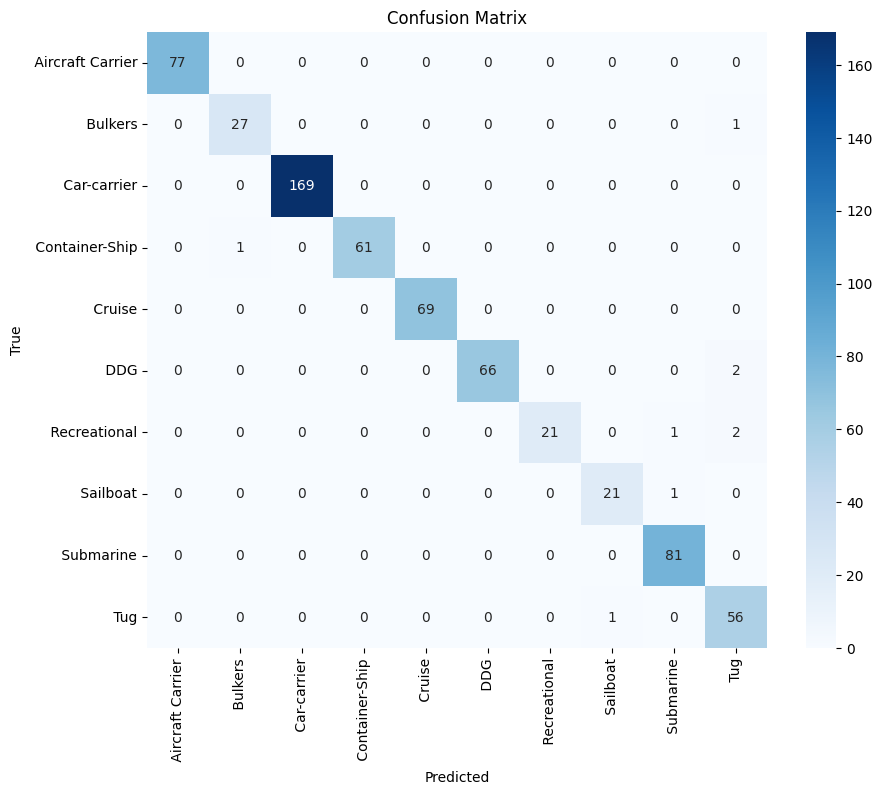

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.label_encoder.classes_, yticklabels=train_dataset.label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

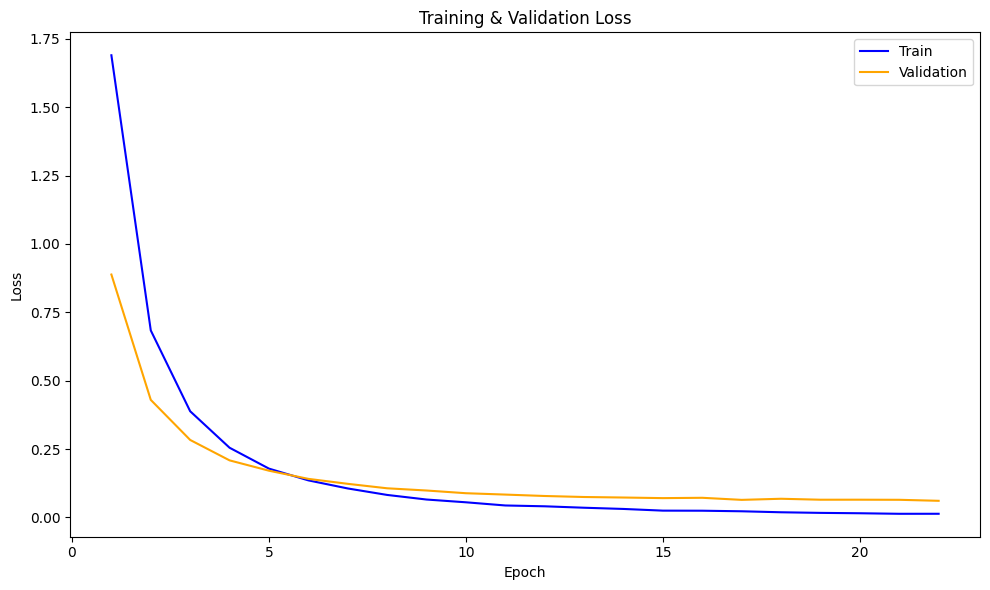

In [24]:
actual_epochs = len(train_losses)
plt.figure(figsize=(10, 6))

# Train Loss 그래프, Validation Loss 그래프
plt.plot(range(1, actual_epochs + 1), train_losses, label='Train', color='blue')
plt.plot(range(1, actual_epochs + 1), valid_losses, label='Validation', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# 그래프 출력
plt.tight_layout()
plt.show()

In [25]:
# Test
model.eval()

# 테스트 손실 및 정확도 계산을 위한 변수 초기화
running_test_loss = 0.0
correct_test = 0
total_test = 0

# 테스트 데이터에 대해 기울기 계산을 하지 않음 (메모리 및 계산량 절약)
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 모델을 통해 예측값을 얻음
        outputs = model(inputs)

        # 손실 계산
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()

        # 예측값 계산
        _, predicted = torch.max(outputs.data, 1)

        # 총 테스트 데이터 수와 맞춘 예측의 개수를 누적
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

# 테스트 정확도와 손실 계산
test_accuracy = correct_test / total_test
test_loss = running_test_loss / len(test_loader)

# 결과 출력
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Loss: 0.0627
Test Accuracy: 0.9863


In [36]:
def guess(image_path):

    # 이미지 로드 및 전처리
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)  # 배치 차원 추가 (1, C, H, W)

    # 장치로 이동
    img_tensor = img_tensor.to(device)

    # 모델에 이미지 입력하여 예측
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)  # 예측된 클래스의 인덱스

    # 예측된 클래스
    predicted_class = predicted.item()

    # 예측된 클래스의 레이블을 출력 (인코딩된 레이블을 디코딩하여 클래스 이름으로 변환)
    predicted_label = train_dataset.label_encoder.inverse_transform([predicted_class])[0]
    print(f"Predicted ship type: {predicted_label}")

In [37]:
# 내 이미지를 맞출수 있는지 확인
image_path_1 = '/content/images/my_image/my_image_ship_1.jpg'
guess(image_path_1)

Predicted ship type:  Cruise


In [38]:
image_path_2 = '/content/images/my_image/my_image_ship_2.jpg'
guess(image_path_2)

Predicted ship type:  Cruise


In [41]:
image_path_3 = '/content/images/my_image/my_image_ship_3.jpg'
guess(image_path_3)

Predicted ship type:  Cruise


In [45]:
image_path_4 = '/content/images/my_image/my_image_ship_4.jpg'
guess(image_path_4)

Predicted ship type:  Cruise


In [46]:
image_path_5 = '/content/images/my_image/my_image_ship_5.jpg'
guess(image_path_5)

Predicted ship type:  Aircraft Carrier


In [47]:
image_path_6 = '/content/images/my_image/my_image_ship_6.jpg'
guess(image_path_6)

Predicted ship type:  Submarine


In [48]:
image_path_7 = '/content/images/my_image/my_image_ship_7.jpg'
guess(image_path_7)

Predicted ship type:  DDG


In [51]:
image_path_8 = '/content/images/my_image/my_image_ship_8.jpg'
guess(image_path_8)

Predicted ship type:  DDG


In [52]:
image_path_9 = '/content/images/my_image/my_image_ship_9.jpg'
guess(image_path_9)

Predicted ship type:  Sailboat


In [53]:
image_path_10 = '/content/images/my_image/my_image_ship_10.jpg'
guess(image_path_10)

Predicted ship type:  Container-Ship


In [54]:
image_path_11 = '/content/images/my_image/my_image_ship_11.jpg'
guess(image_path_11)

Predicted ship type:  Bulkers


In [55]:
image_path_12 = '/content/images/my_image/my_image_ship_12.jpg'
guess(image_path_12)

Predicted ship type:  Car-carrier


In [56]:
image_path_13 = '/content/images/my_image/my_image_ship_13.jpg'
guess(image_path_13)

Predicted ship type:  Tug
